In [ ]:
from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli, average_gate_fidelity
from rl_qoc import PPOConfig, CustomPPO
from rl_qoc import RescaleAndClipAction

from gymnasium.spaces import Box
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli, average_gate_fidelity
from rl_qoc import PPOConfig, CustomPPO
from rl_qoc import RescaleAndClipAction

from gymnasium.spaces import Box
import numpy as np
import matplotlib.pyplot as plt

# state test 0 simplified 1 qubit circuit of one parameter
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
    qc.ry(params[0], 0)

# 1 qubit parametrized state of one parameter
theta = np.pi/8 #generate a random target state; this is the goal we want to obtain
tgt_state = np.cos(theta/2) * Statevector.from_label('0') + np.sin(theta/2) * Statevector.from_label('1')

#params = np.array([[theta]])
params = np.array([[np.random.rand()*np.pi] for i in range(2)]) # for only one parameter in the circuit, over a few batches


"""___________________________________________________________________________________________________________"""
def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2
    
    return max(int(np.ceil(N.real * K)), 10000), int(K), M           #sometimes N = 0. A limit of 10000 is set to prevent this

#create state
state_target = StateTarget(tgt_state)
params = np.array([np.random.rand()*2* np.pi for n in range(6)])  #just to define the shape of params
backend_config = QiskitConfig(apply_parametrized_gate)

reward_name = ["fidelity", "channel", "state", "xeb", "cafe", "orbit", "shadow"]  #channel, cafe, orbit for gate only   fidelity, state, shadow for state only  #xeb gives error
config = QEnvConfig(
    target = state_target,
    backend_config = backend_config,
    action_space = Box(low= 0, high = 2 * np.pi, shape=(1,)),
    execution_config = ExecutionConfig(batch_size = 20, sampling_paulis = 1000, n_shots=1, seed=42),
    reward = reward_name[-1],   # change
    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)

Qenv = QuantumEnvironment(config)


# create agent
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)

c:\Users\Admin\.conda\envs\rl_qoc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Admin\Documents\Python Scripts\Quantum_Optimal_Control\rl_qoc\helpers\__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")


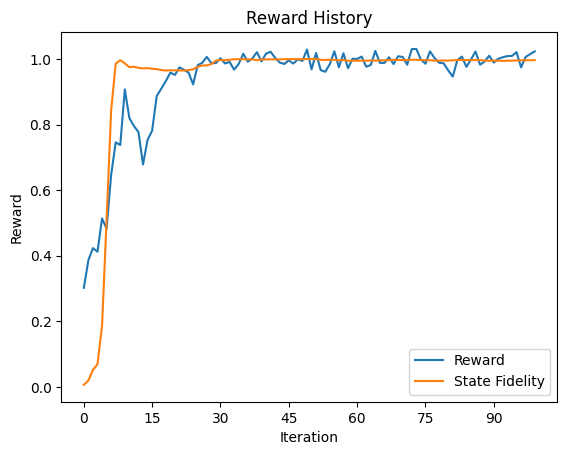

(27, 31)

<Figure size 640x480 with 0 Axes>

In [2]:
# training
from rl_qoc.agent import TrainFunctionSettings, TrainingConfig, TotalUpdates
total_update = TotalUpdates(100)
target_fidelity = 0.99
training_config = TrainingConfig(training_constraint=total_update) #, target_fidelities=[target_fidelity])  #target_fidelities to be specified as a goal
function_settings = TrainFunctionSettings(plot_real_time=True)
result = agent.train(training_config=training_config, train_function_settings=function_settings)

def find_convergence(result, param_len):
    value_reward = result["avg_reward"]

    keys_std = [f"std_action_{n}" for n in range(param_len)]
    result_std = {k: v for k, v in result.items() if k in keys_std}
    value_std = np.array([v for v in result_std.values()])
    geom_mean_std = np.prod(value_std/(2*np.pi), axis=0)**(1/param_len)
    iteration_reward = 0
    iteration_std = 0
    for i in range(len(value_reward)):
        if value_reward[i] >= 0.99:
            iteration_reward = i
            break

    for i in range(len(geom_mean_std)):
        if geom_mean_std[i] <=0.01:
            iteration_std = i
            break
    
    #iteration = max(iteration_reward, iteration_std)
    return iteration_reward, iteration_std
param_len = 1
convergence_iter = find_convergence(result, param_len)
print(convergence_iter)

In [ ]:
key = [k for k in result.keys()]
value = [v for v in result.values()]
length_count = [len(v) for v in value]
max_length = max(length_count)
result_impt = {k: v for k, v in result.items() if len(v) == max_length}
key_impt = list(result_impt.keys())
value_impt = list(result_impt.values())


"""
#plotting only
x = np.linspace(0, max_length-1, max_length)
for k, v in result_impt.items():
    plt.figure()                # creates a new figure each loop
    plt.plot(x, v)
    plt.title(k)
    plt.xlabel("Iterations")
    plt.ylabel(k)
    plt.grid(True)
    plt.show()
"""

import pandas as pd
df = pd.DataFrame(result_impt)    
df.to_csv("C:\\Users\\Admin\\Documents\\Python Scripts\\PC5286 Project\\results\\1_q_s.csv", index=False)

In [23]:
from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli, average_gate_fidelity
from rl_qoc import PPOConfig, CustomPPO
from rl_qoc import RescaleAndClipAction

from gymnasium.spaces import Box
import numpy as np
import matplotlib.pyplot as plt
"""___________________________________________________________________________________________________________"""
#state test 1 full 2 qubit circuit
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
    qc.u(params[0], params[1],params[2], 0)
    qc.u(params[3], params[4],params[5], 1)
    qc.cx(0,1)

def qc_target(params):
    
    qc = QuantumCircuit(2)
    qc.u(params[0], params[1],params[2], 0)
    qc.u(params[3], params[4],params[5], 1)
    qc.cx(0,1)

    return qc

param_len = 6
np.random.seed(43)
params = np.random.rand(param_len)*2* np.pi
tgt_state = Statevector(qc_target(params))


"""___________________________________________________________________________________________________________"""
def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2

    return max(int(np.ceil(N.real * K)), 100), int(K), M           #sometimes N = 0. A limit of 100 is set to prevent this

#create state
state_target = StateTarget(tgt_state)
backend_config = QiskitConfig(apply_parametrized_gate)

reward_name = ["fidelity", "channel", "state", "xeb", "cafe", "orbit", "shadow"]  #channel, cafe, orbit for gate only   fidelity, state, shadow for state only  #xeb gives error
config = QEnvConfig(
    target = state_target,
    backend_config = backend_config,
    action_space = Box(low=np.array([0 for i in range(len(params))]), high=np.array([2*np.pi for i in range(len(params))]), shape=(len(params),)),
    execution_config = ExecutionConfig(batch_size = 20, sampling_paulis = 1000, n_shots=1, seed=42),  #use dfe_... for partition failure rate
    reward = reward_name[2],   # change
    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)

Qenv = QuantumEnvironment(config)


# create agent
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)

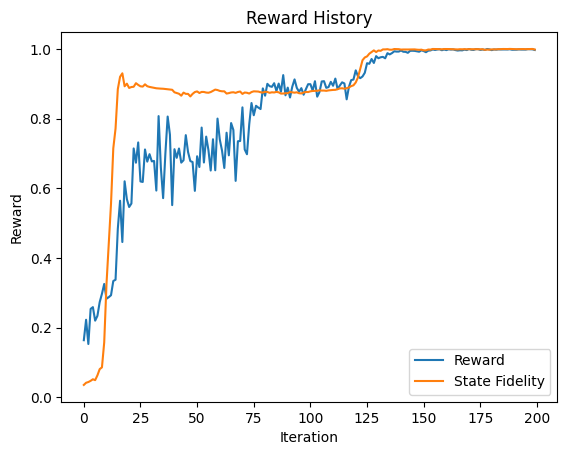

(137, 146)


<Figure size 640x480 with 0 Axes>

In [24]:
# training
from rl_qoc.agent import TrainFunctionSettings, TrainingConfig, TotalUpdates
total_update = TotalUpdates(200)
target_fidelity = 0.99
training_config = TrainingConfig(training_constraint=total_update) #target_fidelities=[target_fidelity])  #target_fidelities to be specified as a goal
function_settings = TrainFunctionSettings(plot_real_time=True)
result = agent.train(training_config=training_config, train_function_settings=function_settings)

def find_convergence(result, param_len):
    value_reward = result["avg_reward"]

    keys_std = [f"std_action_{n}" for n in range(param_len)]
    result_std = {k: v for k, v in result.items() if k in keys_std}
    value_std = np.array([v for v in result_std.values()])
    geom_mean_std = np.prod(value_std/(2*np.pi), axis=0)**(1/param_len)
    iteration_reward = 0
    iteration_std = 0
    for i in range(len(value_reward)):
        if value_reward[i] >= 0.99:
            iteration_reward = i
            break

    for i in range(len(geom_mean_std)):
        if geom_mean_std[i] <=0.01:
            iteration_std = i
            break
    
    #iteration = max(iteration_reward, iteration_std)
    return iteration_reward, iteration_std
    
convergence_iter = find_convergence(result, param_len)
print(convergence_iter)

In [25]:
key = [k for k in result.keys()]
value = [v for v in result.values()]
length_count = [len(v) for v in value]
max_length = max(length_count)
result_impt = {k: v for k, v in result.items() if len(v) == max_length}
key_impt = list(result_impt.keys())
value_impt = list(result_impt.values())

"""

plotting only
x = np.linspace(0, max_length-1, max_length)
for k, v in result_impt.items():
    plt.figure()                # creates a new figure each loop
    plt.plot(x, v)
    plt.title(k)
    plt.xlabel("Iterations")
    plt.ylabel(k)
    plt.grid(True)
    plt.show()
"""
import pandas as pd
df = pd.DataFrame(result_impt)    
df.to_csv("C:\\Users\\Admin\\Documents\\Python Scripts\\PC5286 Project\\results\\2_q_s_sta.csv", index=False)

In [18]:
"""

key = [k for k in result.keys()]
value = [v for v in result.values()]
length_count = [len(v) for v in value]
max_length = max(length_count)
result_impt = {k: v for k, v in result.items() if len(v) == max_length}
key_impt = list(result_impt.keys())
value_impt = list(result_impt.values())



plotting only
x = np.linspace(0, max_length-1, max_length)
for k, v in result_impt.items():
    plt.figure()                # creates a new figure each loop
    plt.plot(x, v)
    plt.title(k)
    plt.xlabel("Iterations")
    plt.ylabel(k)
    plt.grid(True)
    plt.show()

import pandas as pd
df = pd.DataFrame(result_impt)    
df.to_csv("C:\\Users\\Admin\\Documents\\Python Scripts\\PC5286 Project\\results\\2_q_s.csv", index=False)
"""
    

'\n\nkey = [k for k in result.keys()]\nvalue = [v for v in result.values()]\nlength_count = [len(v) for v in value]\nmax_length = max(length_count)\nresult_impt = {k: v for k, v in result.items() if len(v) == max_length}\nkey_impt = list(result_impt.keys())\nvalue_impt = list(result_impt.values())\n\n\n\nplotting only\nx = np.linspace(0, max_length-1, max_length)\nfor k, v in result_impt.items():\n    plt.figure()                # creates a new figure each loop\n    plt.plot(x, v)\n    plt.title(k)\n    plt.xlabel("Iterations")\n    plt.ylabel(k)\n    plt.grid(True)\n    plt.show()\n\nimport pandas as pd\ndf = pd.DataFrame(result_impt)    \ndf.to_csv("C:\\Users\\Admin\\Documents\\Python Scripts\\PC5286 Project\\results\\2_q_s.csv", index=False)\n'

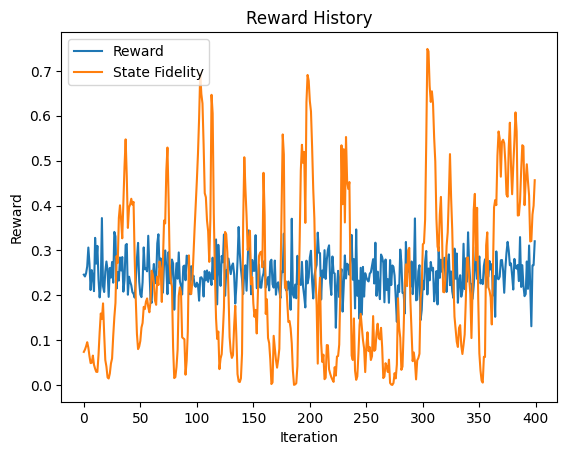

<Figure size 640x480 with 0 Axes>

In [6]:
from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli, average_gate_fidelity
from rl_qoc import PPOConfig, CustomPPO
from rl_qoc import RescaleAndClipAction

from gymnasium.spaces import Box
import numpy as np
import matplotlib.pyplot as plt
"""___________________________________________________________________________________________________________"""
#state test 2 full 2 qubit circuit
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
        # block 0
        qc.u(params[0],  params[1],  params[2],  0)
        qc.u(params[3],  params[4],  params[5],  1)
        qc.cx(0, 1)

        # block 1
        qc.u(params[6],  params[7],  params[8],  0)
        qc.u(params[9],  params[10], params[11], 1)
        qc.cx(1, 0)

        # block 2
        qc.u(params[12], params[13], params[14], 0)
        qc.u(params[15], params[16], params[17], 1)
        qc.cx(0, 1)

        # block 3
        qc.u(params[18], params[19], params[20], 0)
        qc.u(params[21], params[22], params[23], 1)


def qc_target(params):
        """
        Universal 2-qubit ansatz (covers SU(4)):
        [U⊗U] - CX(0,1) - [U⊗U] - CX(1,0) - [U⊗U] - CX(0,1) - [U⊗U]
        params: length 24 (8 single-qubit U's × 3 params each).
        """
        if len(params) != 24:
            raise ValueError("params must have length 24")
        qc = QuantumCircuit(2, name="U_su4")

        # block 0
        qc.u(params[0],  params[1],  params[2],  0)
        qc.u(params[3],  params[4],  params[5],  1)
        qc.cx(0, 1)

        # block 1
        qc.u(params[6],  params[7],  params[8],  0)
        qc.u(params[9],  params[10], params[11], 1)
        qc.cx(1, 0)

        # block 2
        qc.u(params[12], params[13], params[14], 0)
        qc.u(params[15], params[16], params[17], 1)
        qc.cx(0, 1)

        # block 3
        qc.u(params[18], params[19], params[20], 0)
        qc.u(params[21], params[22], params[23], 1)

        return qc

param_len = 24
no_qubits = 2
np.random.seed(43)
params = np.random.rand(param_len)* 2 * np.pi  
tgt_state = Statevector(qc_target(params))


"""___________________________________________________________________________________________________________"""
def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2

    return max(int(np.ceil(N.real * K)), 100), int(K), M           #sometimes N = 0. A limit of 100 is set to prevent this

#create state
state_target = StateTarget(tgt_state)
backend_config = QiskitConfig(apply_parametrized_gate)

reward_name = ["fidelity", "channel", "state", "xeb", "cafe", "orbit", "shadow"]  #channel, cafe, orbit for gate only   fidelity, state, shadow for state only  #xeb gives error
config = QEnvConfig(
    target = state_target,
    backend_config = backend_config,
    action_space = Box(low=np.array([0 for i in range(len(params))]), high=np.array([2*np.pi for i in range(len(params))]), shape=(len(params),)),
    execution_config = ExecutionConfig(batch_size = 20, sampling_paulis = 1000, n_shots=1, seed=42),  #use dfe_... for partition failure rate
    reward = reward_name[-1],   # change
    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)

Qenv = QuantumEnvironment(config)


# create agent
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)

# training
from rl_qoc.agent import TrainFunctionSettings, TrainingConfig, TotalUpdates
total_update = TotalUpdates(400)
target_fidelity = 0.99
training_config = TrainingConfig(training_constraint=total_update) #target_fidelities=[target_fidelity])  #target_fidelities to be specified as a goal
function_settings = TrainFunctionSettings(plot_real_time=True)
result = agent.train(training_config=training_config, train_function_settings=function_settings)


In [6]:
#gate target test 0
from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli, average_gate_fidelity
from rl_qoc import PPOConfig, CustomPPO
from rl_qoc import RescaleAndClipAction

from gymnasium.spaces import Box
import numpy as np
import matplotlib.pyplot as plt

def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2
    
    return max(int(np.ceil(N.real * K)), 10000), int(K), M           #sometimes N = 0. A limit of 10000 is set to prevent this

"""_____________________________________________________________________________________________________________________________________________________________________________________________________"""


# simplified 1 qubit circuit of one parameter
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
    qc.ry(2*params[0], 0)

#create random 1 qubit gate and obtain its choi state
params = np.random.rand(1)*2* np.pi
qc = QuantumCircuit(1)
qc.ry(2*params[0], 0)

specific_gate = qc.to_gate(label="U_entangle")
gate_target = GateTarget(specific_gate)

reward_name = ["fidelity", "channel", "state", "xeb", "cafe", "orbit", "shadow"]  #channel, cafe, orbit for gate only   fidelity, state, shadow for state only  #xeb gives error
backend_config = QiskitConfig(apply_parametrized_gate)

config = QEnvConfig(target = gate_target, 
                    backend_config=backend_config,
                    execution_config=ExecutionConfig(batch_size = 20, sampling_paulis = 1000, n_shots=50, seed=42),
                    action_space = Box(low=np.array([0 for i in range(len(params))]), high=np.array([2*np.pi for i in range(len(params))]), shape=(len(params),)),
                    reward=reward_name[-1],
                    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)
Qenv = QuantumEnvironment(config)


# create agent
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)


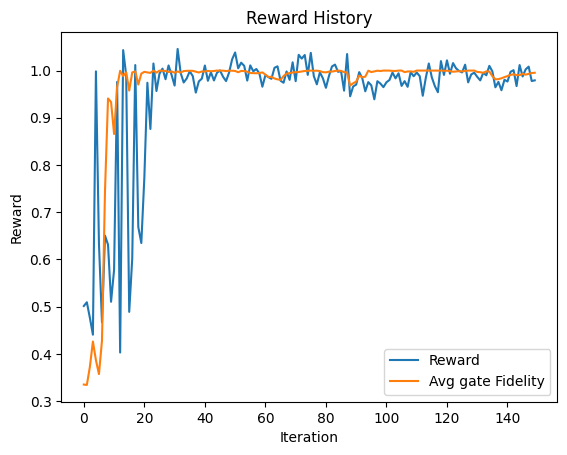

(4, 26)


<Figure size 640x480 with 0 Axes>

In [7]:
# training
from rl_qoc.agent import TrainFunctionSettings, TrainingConfig, TotalUpdates
total_update = TotalUpdates(150)
target_fidelity = 0.98
training_config = TrainingConfig(training_constraint=total_update) #  target_fidelities=[target_fidelity])  #target_fidelities to be specified as a goal
function_settings = TrainFunctionSettings(plot_real_time=True)
result = agent.train(training_config=training_config, train_function_settings=function_settings)

def find_convergence(result, param_len):
    value_reward = result["avg_reward"]

    keys_std = [f"std_action_{n}" for n in range(param_len)]
    result_std = {k: v for k, v in result.items() if k in keys_std}
    value_std = np.array([v for v in result_std.values()])
    geom_mean_std = np.prod(value_std/(2*np.pi), axis=0)**(1/param_len)
    iteration_reward = 0
    iteration_std = 0
    for i in range(len(value_reward)):
        if value_reward[i] >= 0.99:
            iteration_reward = i
            break

    for i in range(len(geom_mean_std)):
        if geom_mean_std[i] <=0.01:
            iteration_std = i
            break
    
    #iteration = max(iteration_reward, iteration_std)
    return iteration_reward, iteration_std

param_len = 1
convergence_iter = find_convergence(result, param_len)
print(convergence_iter)

In [8]:
key = [k for k in result.keys()]
value = [v for v in result.values()]
length_count = [len(v) for v in value]
max_length = max(length_count)
result_impt = {k: v for k, v in result.items() if len(v) == max_length}
key_impt = list(result_impt.keys())
value_impt = list(result_impt.values())

"""

plotting only
x = np.linspace(0, max_length-1, max_length)
for k, v in result_impt.items():
    plt.figure()                # creates a new figure each loop
    plt.plot(x, v)
    plt.title(k)
    plt.xlabel("Iterations")
    plt.ylabel(k)
    plt.grid(True)
    plt.show()
"""
import pandas as pd
df = pd.DataFrame(result_impt)    
df.to_csv("C:\\Users\\Admin\\Documents\\Python Scripts\\PC5286 Project\\results\\1_q_g_cst.csv", index=False)

In [1]:
#gate target test 1

from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli, average_gate_fidelity
from rl_qoc import PPOConfig, CustomPPO
from rl_qoc import RescaleAndClipAction

from gymnasium.spaces import Box
import numpy as np

def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2
    
    return max(int(np.ceil(N.real * K)), 10000), int(K), M           #sometimes N = 0. A limit of 10000 is set to prevent this

"""_____________________________________________________________________________________________________________________________________________________________________________________________________"""


# build the parametrized circuit of a generic 2 qubit circuit of 6 parameters
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
    qc.u(params[0], params[1],params[2], 0)
    qc.u(params[3], params[4],params[5], 1)
    qc.cx(0,1)


def qc_target(params):
    
    qc = QuantumCircuit(2)
    qc.u(params[0], params[1],params[2], 0)
    qc.u(params[3], params[4],params[5], 1)
    qc.cx(0,1)

    return qc

param_len = 6
np.random.seed(43)
params = ParameterVector("theta", param_len)
qc = qc_target(params)

param_random = np.random.rand(param_len)* 2* np.pi
qc1 = qc_target(param_random)

# Create parameterized gate
param_gate = qc.to_gate(label="U_entangle")
bound_qc = qc.assign_parameters({
    params[i]: param_random[i] for i in range(param_len)
})

specific_gate = bound_qc.to_gate(label="U_entangle")
gate_target = GateTarget(specific_gate)

reward_name = ["fidelity", "channel", "state", "xeb", "cafe", "orbit", "shadow"]  #channel, cafe, orbit for gate only   fidelity, state, shadow for state only  #xeb gives error
backend_config = QiskitConfig(apply_parametrized_gate)

config = QEnvConfig(target = gate_target, 
                    backend_config=backend_config,
                    execution_config=ExecutionConfig(batch_size = 20, sampling_paulis = 20, n_shots=50, seed=42),
                    action_space = Box(low=np.array([0 for i in range(len(params))]), high=np.array([2*np.pi for i in range(len(params))]), shape=(len(params),)),
                    reward=reward_name[-2],
                    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)
Qenv = QuantumEnvironment(config)


# create agent
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)
 

c:\Users\Admin\.conda\envs\rl_qoc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Admin\Documents\Python Scripts\Quantum_Optimal_Control\rl_qoc\helpers\__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")
c:\Users\Admin\.conda\envs\rl_qoc\lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


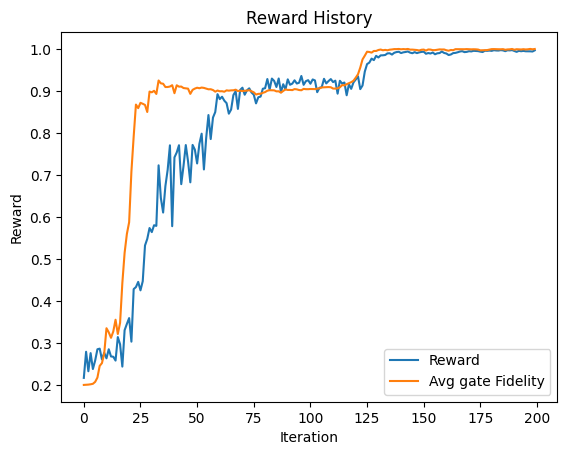

(137, 69)


<Figure size 640x480 with 0 Axes>

In [2]:
# training
from rl_qoc.agent import TrainFunctionSettings, TrainingConfig, TotalUpdates
total_update = TotalUpdates(200)
#target_fidelity = 0.98
training_config = TrainingConfig(training_constraint=total_update)  #target_fidelities to be specified as a goal
function_settings = TrainFunctionSettings(plot_real_time=True)
result = agent.train(training_config=training_config, train_function_settings=function_settings)
# print(param_random)
# print(Qenv.optimal_action)
# qc2 = qc_target(Qenv.optimal_action)
# print(Operator(qc1), Operator(qc2))
# print(average_gate_fidelity(Operator(qc1), Operator(qc2)))

def find_convergence(result, param_len):
    value_reward = result["avg_reward"]

    keys_std = [f"std_action_{n}" for n in range(param_len)]
    result_std = {k: v for k, v in result.items() if k in keys_std}
    value_std = np.array([v for v in result_std.values()])
    geom_mean_std = np.prod(value_std/(2*np.pi), axis=0)**(1/param_len)
    iteration_reward = 0
    iteration_std = 0
    for i in range(len(value_reward)):
        if value_reward[i] >= 0.99:
            iteration_reward = i
            break

    for i in range(len(geom_mean_std)):
        if geom_mean_std[i] <=0.01:
            iteration_std = i
            break
    
    #iteration = max(iteration_reward, iteration_std)
    return iteration_reward, iteration_std

convergence_iter = find_convergence(result, param_len)
print(convergence_iter)


In [24]:
key = [k for k in result.keys()]
value = [v for v in result.values()]
length_count = [len(v) for v in value]
max_length = max(length_count)
result_impt = {k: v for k, v in result.items() if len(v) == max_length}
key_impt = list(result_impt.keys())
value_impt = list(result_impt.values())

"""

plotting only
x = np.linspace(0, max_length-1, max_length)
for k, v in result_impt.items():
    plt.figure()                # creates a new figure each loop
    plt.plot(x, v)
    plt.title(k)
    plt.xlabel("Iterations")
    plt.ylabel(k)
    plt.grid(True)
    plt.show()
"""
import pandas as pd
df = pd.DataFrame(result_impt)    
df.to_csv("C:\\Users\\Admin\\Documents\\Python Scripts\\PC5286 Project\\results\\2_q_g_channel.csv", index=False)

In [ ]:
#gate target test 2; 24 parameters; too many parameters doesnt work?

from rl_qoc import QuantumEnvironment, QiskitConfig, QEnvConfig, ExecutionConfig, StateTarget, ShadowReward, GateTarget, BenchmarkConfig
from qiskit.circuit import QuantumCircuit, ParameterVector, QuantumRegister
from qiskit.circuit.library import RXGate, UGate, RZXGate
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, random_statevector, Choi, Operator, SuperOp, SparsePauliOp, Pauli, average_gate_fidelity
from rl_qoc import PPOConfig, CustomPPO
from rl_qoc import RescaleAndClipAction

from gymnasium.spaces import Box
import numpy as np

def shadow_bound_state(error, observables, coeffs, failure_rate=0.01):
   
    M = len(observables)
    K = 2 * np.log(2 * M / failure_rate)
    shadow_norm = (
        lambda op: np.linalg.norm(
            op - np.trace(op) / 2 ** int(np.log2(op.shape[0])), ord=np.inf
        )
        ** 2
    )
    N = 34 * max(shadow_norm(observables[i]) * coeffs[i]**2 for i in range(len(observables))) / error ** 2

    return max(int(np.ceil(N.real * K)), 100), int(K), M           #sometimes N = 0. A limit of 100 is set to prevent this

"""_____________________________________________________________________________________________________________________________________________________________________________________________________"""


# build the parametrized circuit of a generic 2 qubit circuit of 24 parameters
def apply_parametrized_gate(qc: QuantumCircuit, params: ParameterVector, qr: QuantumRegister, *args, **kwargs):
        # block 0
        qc.u(params[0],  params[1],  params[2],  0)
        qc.u(params[3],  params[4],  params[5],  1)
        qc.cx(0, 1)

        # block 1
        qc.u(params[6],  params[7],  params[8],  0)
        qc.u(params[9],  params[10], params[11], 1)
        qc.cx(1, 0)

        # block 2
        qc.u(params[12], params[13], params[14], 0)
        qc.u(params[15], params[16], params[17], 1)
        qc.cx(0, 1)

        # block 3
        qc.u(params[18], params[19], params[20], 0)
        qc.u(params[21], params[22], params[23], 1)


def qc_target(params):
        """
        Universal 2-qubit ansatz (covers SU(4)):
        [U⊗U] - CX(0,1) - [U⊗U] - CX(1,0) - [U⊗U] - CX(0,1) - [U⊗U]
        params: length 24 (8 single-qubit U's × 3 params each).
        """
        if len(params) != 24:
            raise ValueError("params must have length 24")
        qc = QuantumCircuit(2, name="U_su4")

        # block 0
        qc.u(params[0],  params[1],  params[2],  0)
        qc.u(params[3],  params[4],  params[5],  1)
        qc.cx(0, 1)

        # block 1
        qc.u(params[6],  params[7],  params[8],  0)
        qc.u(params[9],  params[10], params[11], 1)
        qc.cx(1, 0)

        # block 2
        qc.u(params[12], params[13], params[14], 0)
        qc.u(params[15], params[16], params[17], 1)
        qc.cx(0, 1)

        # block 3
        qc.u(params[18], params[19], params[20], 0)
        qc.u(params[21], params[22], params[23], 1)

        return qc

param_len = 24
params = ParameterVector("theta", param_len)
qc = qc_target(params)
np.random.seed(42)
param_random = np.random.rand(param_len)* 2* np.pi
qc1 = qc_target(param_random)

# Create parameterized gate
param_gate = qc.to_gate(label="U_entangle")
bound_qc = qc.assign_parameters({
    params[i]: param_random[i] for i in range(param_len)
})

specific_gate = bound_qc.to_gate(label="U_entangle")
gate_target = GateTarget(specific_gate)

reward_name = ["fidelity", "channel", "state", "xeb", "cafe", "orbit", "shadow"]  #channel, cafe, orbit for gate only   fidelity, state, shadow for state only  #xeb gives error
backend_config = QiskitConfig(apply_parametrized_gate)

config = QEnvConfig(target = gate_target, 
                    backend_config=backend_config,
                    execution_config=ExecutionConfig(batch_size = 50, sampling_paulis = 2000, n_shots=1, seed=42),
                    action_space = Box(low=np.array([0 for i in range(param_len)]), high=np.array([2*np.pi for i in range(param_len)]), shape=(param_len,)),
                    reward=reward_name[-1],
                    benchmark_config = BenchmarkConfig(benchmark_cycle = 1)
)
Qenv = QuantumEnvironment(config)


# create agent
agent_config = PPOConfig.from_yaml("agent_config.yaml")  # may need to specify entire path
rescaled_env = RescaleAndClipAction(Qenv, min_action=-1, max_action=1)
agent = CustomPPO(agent_config = agent_config, env=rescaled_env)
 

c:\Users\Admin\.conda\envs\rl_qoc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Admin\Documents\Python Scripts\Quantum_Optimal_Control\rl_qoc\helpers\__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")
c:\Users\Admin\.conda\envs\rl_qoc\lib\site-packages\gymnasium\spaces\box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


: 

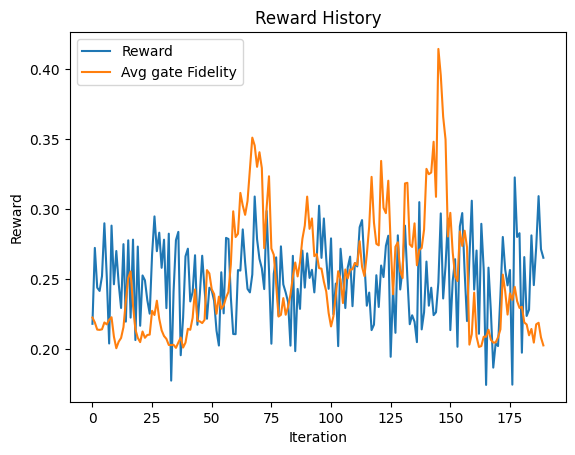


 Number of repetitions: 1
Starting simulation benchmark...
Avg gate fidelity: [0.20063513281255924]
Finished simulation benchmark
Reward (avg): 0.25911818927443797 Std: 0.1989241633959046

 Number of repetitions: 1
Starting simulation benchmark...
Avg gate fidelity: [0.20429480909763117]
Finished simulation benchmark
Reward (avg): 0.26692310797783475 Std: 0.1930077256460604

 Number of repetitions: 1
Starting simulation benchmark...
Avg gate fidelity: [0.20305232922827182]
Finished simulation benchmark
Reward (avg): 0.2878014766537722 Std: 0.22452237879200523

 Number of repetitions: 1
Starting simulation benchmark...
Avg gate fidelity: [0.20025082250163365]
Finished simulation benchmark
Reward (avg): 0.2158238868299241 Std: 0.17276549888184436

 Number of repetitions: 1
Starting simulation benchmark...
Avg gate fidelity: [0.20889652913268858]
Finished simulation benchmark
Reward (avg): 0.2606677095548854 Std: 0.20230747634845736

 Number of repetitions: 1
Starting simulation benchmar

: 

In [ ]:
# training
from rl_qoc.agent import TrainFunctionSettings, TrainingConfig, TotalUpdates
total_update = TotalUpdates(200)
#target_fidelity = 0.98
training_config = TrainingConfig(training_constraint=total_update)  #target_fidelities to be specified as a goal
function_settings = TrainFunctionSettings(plot_real_time=True)
result = agent.train(training_config=training_config, train_function_settings=function_settings)
print(param_random)
print(Qenv.optimal_action)
qc2 = qc_target(Qenv.optimal_action)
print(Operator(qc1), Operator(qc2))
print(average_gate_fidelity(Operator(qc1), Operator(qc2)))

In [ ]:
key = [k for k in result.keys()]
value = [v for v in result.values()]
length_count = [len(v) for v in value]
max_length = max(length_count)

x = np.linspace(0, max_length-1, max_length)
result_impt = {k: v for k, v in result.items() if len(v) == max_length}
key_impt = list(result_impt.keys())
value_impt = list(result_impt.values())

"""
for k, v in result_impt.items():
    plt.figure()                # creates a new figure each loop
    plt.plot(x, v)
    plt.title(k)
    plt.xlabel("Iterations")
    plt.ylabel(k)
    plt.grid(True)
    plt.show()
"""
import pandas as pd
df = pd.DataFrame(result_impt)    
df.to_csv("C:\\Users\\Admin\\Documents\\Python Scripts\\PC5286 Project\\results\\2_q_g.csv", index=False)


: 